# Data Exploration for the Eurosat Dataset

## 1. Environment Setup

### 1.1 Colab Environment

In [14]:
## Mounting drive on Colab to access content
from google.colab import drive
drive.mount('/content/gdrive')

## Appending path of GDrive folder to system path to access private modules and files
import sys
sys.path.append('/content/gdrive/MyDrive/ml-mavericks')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1.2 Imports

In [16]:

### Torch modules
from torchvision import transforms

### Rasterio modules
import rasterio
from rasterio.plot import reshape_as_image

### Other modules
import os
from tqdm import tqdm
import h5py
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

### Private modules
from utils.utils import EurosatPreloadedDataset, EurosatPreloadedTestset, dataset_first_n, normalize_for_display, plot_histogram_for_rgb

### 1.3 Global Variables

These path variables might need to be adjusted to match with your file system.

In [17]:
## Path to load training and test data (in .H5 format)
TRAINING_PATH = "/content/gdrive/MyDrive/ml-mavericks/data/trainingset_RGB_NDVI.h5"
TEST_PATH = "/content/gdrive/MyDrive/ml-mavericks/data/testset_RGB_NDVI.h5"

# Path to save visualizations
VISUALIZATION_PATH = "/content/gdrive/MyDrive/ml-mavericks/visualisation"

In [18]:
## Initialization of CLASS_LABELS: list of the 10 land cover types covered in Eurosat 
CLASS_LABELS = ["Annual Crop", "Forest", "Herbaceous Vegetation", "Highway", "Industrial", "Pasture", 
                "Permanent Crop", "Residential", "River", "Sea Lake"]

## Initialization of ID2LABEL: dictionary that maps numerical IDs to their corresponding land cover types
ID2LABEL = {0: "Annual Crop", 1: "Forest", 2: "Herbaceous Vegetation", 3: "Highway", 4: "Industrial", 
            5: "Pasture", 6: "Permanent Crop", 7: "Residential", 8: "River", 9: "Sea Lake"}

## 2.0 Data setup

### 2.1 Data Augmentations

In [19]:
## Setting image transformations for training, validation, and testing 
## Transformations include resizing, rotating, flipping, center cropping

## Transformations for training data
transform_train = transforms.Compose([

        ## Transforming data to tensor
        transforms.ToTensor(),

        # enlarge the images by bilinear interpolation                       
        transforms.Resize([92,92], antialias=None),                            

        # rotate the picture by the degree input
        transforms.RandomRotation(5),

        # pad the edges by 10 pixels
        transforms.RandomCrop(112, padding = 10),
        
        # normalize
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # given parameters

    ])

## Transformations for validation data
transform_val = transforms.Compose([

        ## Transforming data to tensor
        transforms.ToTensor(),

        # enlarge the images by bilinear interpolation
        transforms.Resize([92,92], antialias=None),

        # cut the image from the center
        transforms.CenterCrop(112),

        # normalize
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])  

## Transformations for test data
transform_test = transforms.Compose([

        ## Transforming data to tensor
        transforms.ToTensor(),

        # enlarge the images by bilinear interpolation
        transforms.Resize([92,92], antialias=None),

        # cut the image from the center
        transforms.CenterCrop(112),

        # normalize
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])  

### 2.2 Data Loading

In [20]:
## Loading Eurosat dataset for training and testing - without transformations
trainset = EurosatPreloadedDataset(root_dir=TRAINING_PATH, classes=CLASS_LABELS)
testset = EurosatPreloadedTestset(root_dir=TEST_PATH)

## Loading Eurosat dataset for training and testing - with transformations
trainset_transformed = EurosatPreloadedDataset(root_dir=TRAINING_PATH, transform=transform_train, classes=CLASS_LABELS)
testset_transformed = EurosatPreloadedTestset(root_dir=TEST_PATH, transform=transform_test)

## 3.0 Visualisations

### 3.1 Number of samples per class in the training set

In [21]:
## Getting list of class IDs of pictures in the trainset
classIDs = []
for i in tqdm(range(len(trainset.labels))):
  _, label = trainset.__getitem__(i)
  classIDs.append(label)

100%|██████████| 27000/27000 [00:01<00:00, 18931.42it/s]


In [22]:
## Setting image_path for saving
image_path = os.path.join(VISUALIZATION_PATH, "number_of_images_per_class.jpg")

## Extracting the labels from the training set
labels = [ID2LABEL[i] for i in classIDs]

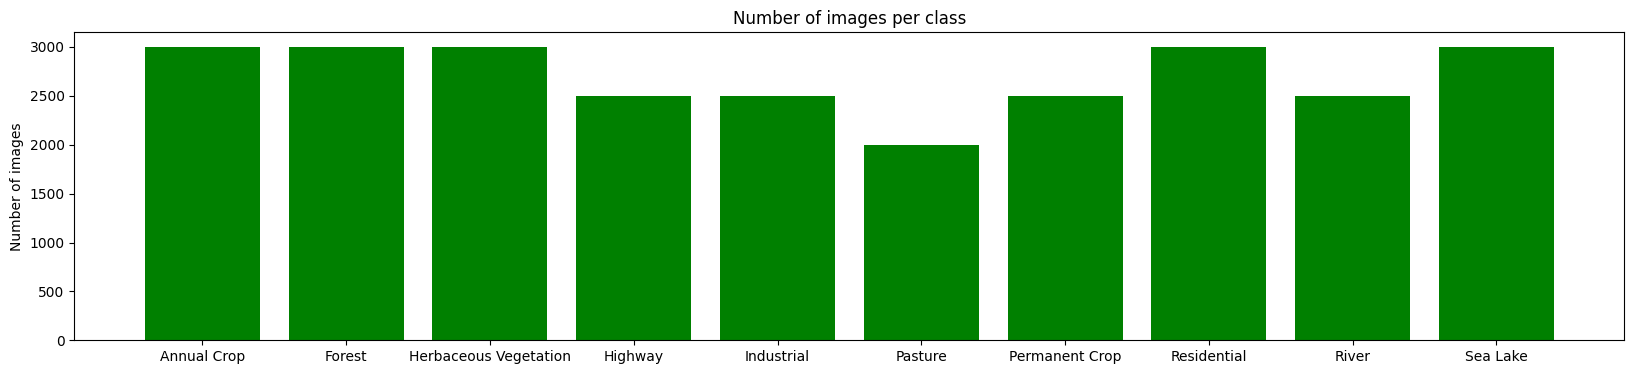

<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

# classes_list is your list of classes
classes_list = labels

# Couting the occurrence of each class in your list
counts = {i:classes_list.count(i) for i in classes_list}

# Creating a new figure with a specific size (width=10, height=8)
plt.figure(figsize=(20,4))

# Plotting the counts
plt.bar(range(len(counts)), list(counts.values()), align='center', color='green')
plt.xticks(range(len(counts)), list(counts.keys()))

# Labeling the axes
plt.ylabel('Number of images')

# Giving a title to the graph
plt.title('Number of images per class')

# Display the graph
plt.show()

# Saving the graph 
plt.savefig(image_path)

### 3.2 Distribution of the training and test set

#### Histograms of training set

We only choose every 5th image out of performance reasons.

In [24]:
train_images = [img for img in trainset.images[::5]]
train_images_normalized = [normalize_for_display(img) for img in train_images]

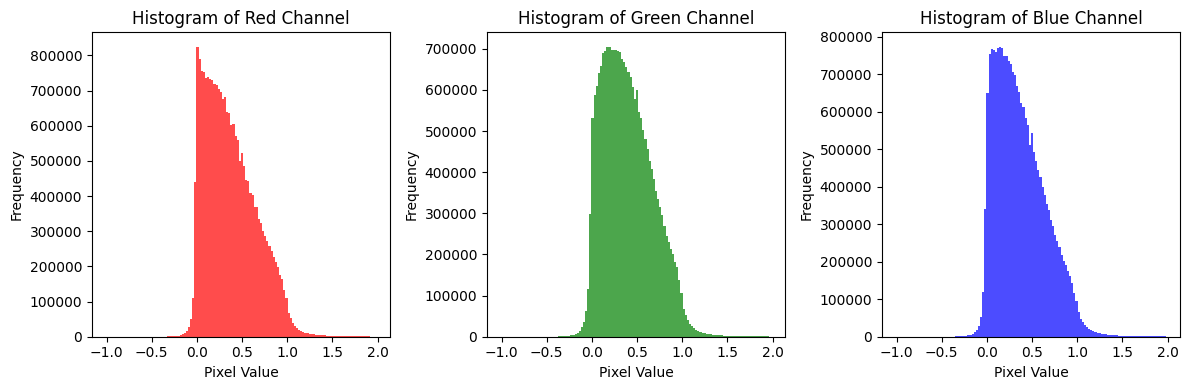

In [25]:
plot_histogram_for_rgb(train_images_normalized)

We can see that the all channels are quite skewed, something we will need to take into account for our model training: Generalization for minority class or values might be more difficult.

#### Histograms of test set

Due to performance reasons we only take every fifth image. Also we apply a normalize function to display the histograms.

In [26]:
test_images = [img for img in testset.images[::5]]
test_images_normalized = [normalize_for_display(img) for img in test_images]

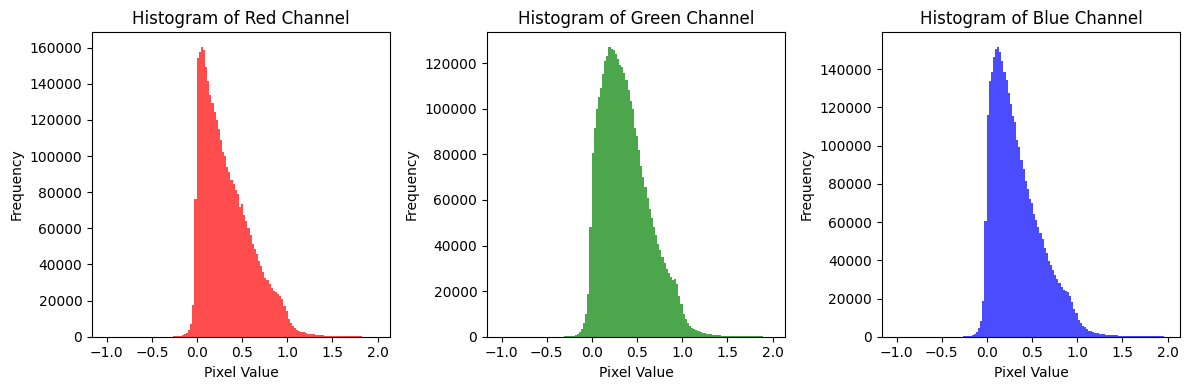

In [27]:
plot_histogram_for_rgb(test_images_normalized)

#### Mean and standard deviation for training and test set

Interesting to know for the data transformations are the values for mean and standard deviation of each channel.

In [28]:
# Gets the mean of the mean of the image list
def get_mean_of_band(band, image_list):
  means = [np.mean(image[:, :, band]) for image in image_list]
  return np.mean(means)

In [29]:
# Gets the mean standard deviation of the image list
def get_std_of_band(band, image_list):
  stds = [np.std(image[:, :, band]) for image in image_list]
  return np.mean(stds)

In [30]:
red_mean = get_mean_of_band(0, train_images)
red_std = get_std_of_band(0, train_images)

print("------- Training -------")
print(f"Red mean: {round(red_mean, 3)}")
print(f"Red std: {round(red_std, 3)}")

red_mean = get_mean_of_band(0, test_images)
red_std = get_std_of_band(0, test_images)

print()
print("------- Test -------")
print(f"Red mean: {round(red_mean, 3)}")
print(f"Red std: {round(red_std, 3)}")

------- Training -------
Red mean: 947.207
Red std: 277.35

------- Test -------
Red mean: 565.895
Red std: 288.799


In [31]:
green_mean = get_mean_of_band(1, train_images)
green_std = get_std_of_band(1, train_images)

print("------- Training -------")
print(f"Green mean: {round(green_mean, 3)}")
print(f"Green std: {round(green_std, 3)}")

green_mean = get_mean_of_band(1, test_images)
green_std = get_std_of_band(1, test_images)

print()
print("------- Test -------")
print(f"Green mean: {round(green_mean, 3)}")
print(f"Green std: {round(green_std, 3)}")

------- Training -------
Green mean: 1042.276
Green std: 187.449

------- Test -------
Green mean: 617.296
Green std: 228.895


In [32]:
blue_mean = get_mean_of_band(2, train_images)
blue_std = get_std_of_band(2, train_images)

print("------- Training -------")
print(f"Blue mean: {round(blue_mean, 3)}")
print(f"Blue std: {round(green_std, 3)}")

blue_mean = get_mean_of_band(2, test_images)
blue_std = get_std_of_band(2, test_images)

print()
print("------- Test -------")
print(f"Blue mean: {round(blue_mean, 3)}")
print(f"Blue std: {round(blue_std, 3)}")

------- Training -------
Blue mean: 1116.682
Blue std: 228.895

------- Test -------
Blue mean: 390.207
Blue std: 197.225


### 3.3 Visualisation of the training & test set (not transformed)

We will first plot an overview of images for each class in the dataset.

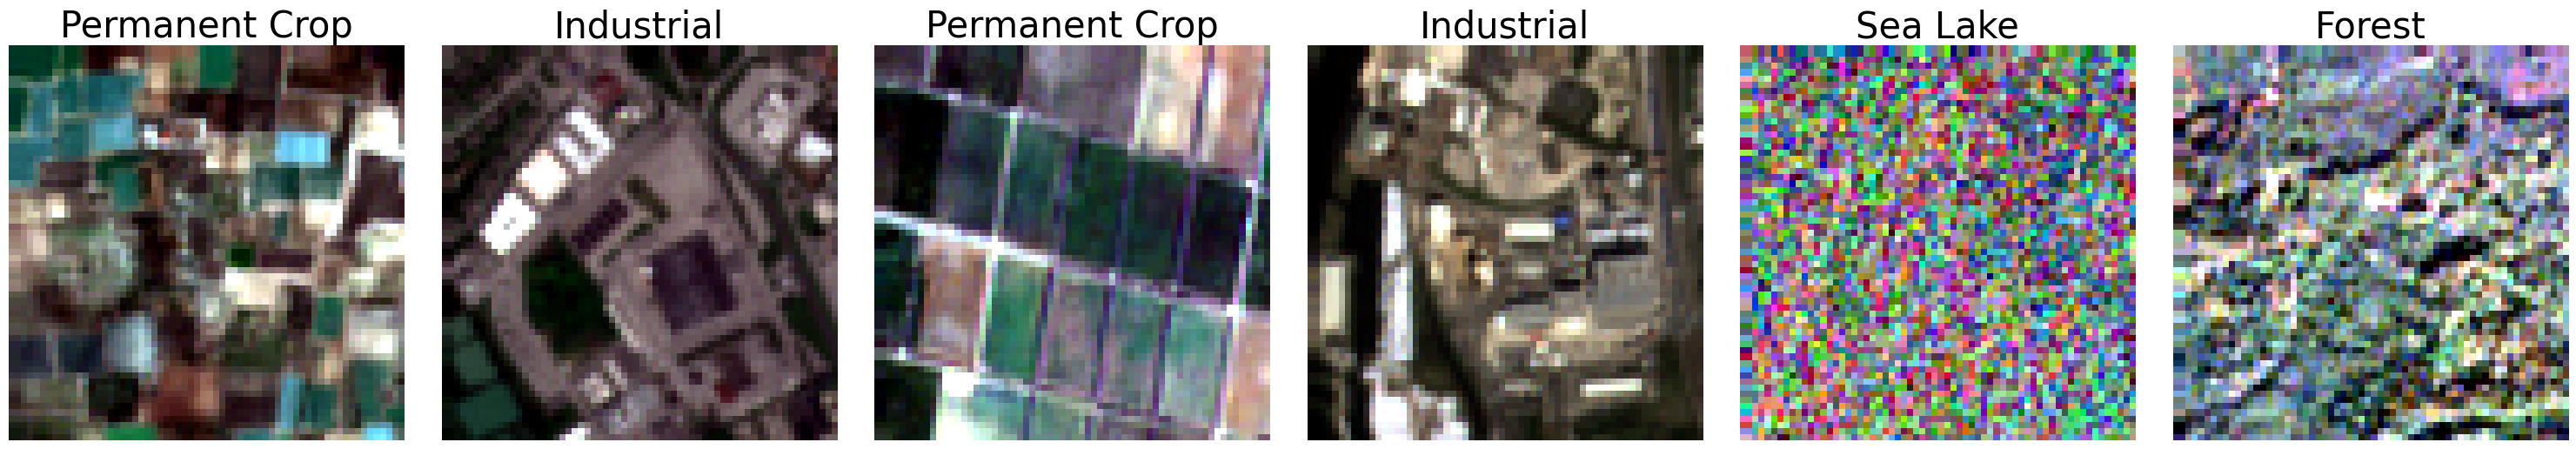

In [ ]:
dataset_first_n(trainset, 6, ID2LABEL)

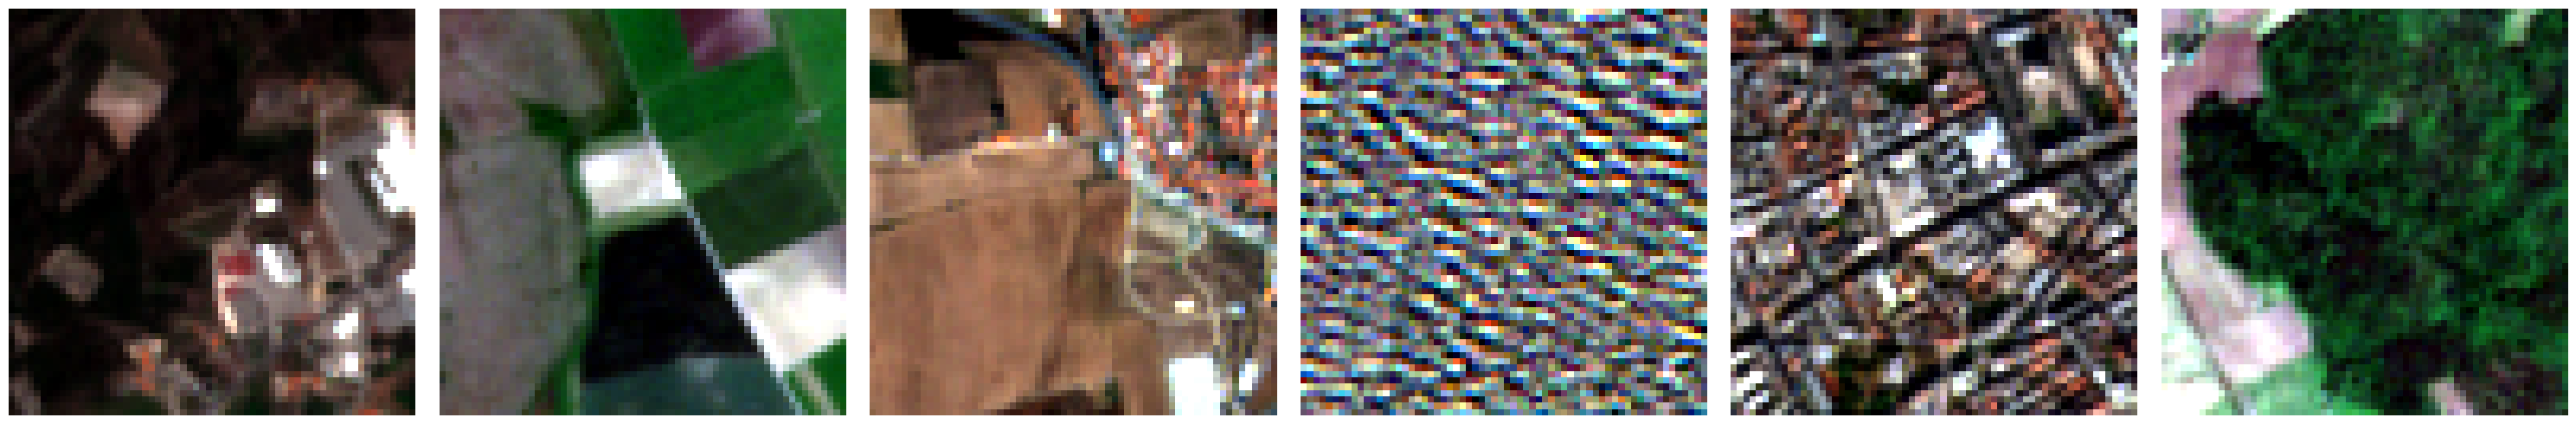

In [ ]:
dataset_first_n(testset, 6)

### 3.3 Visualisation of the train  & test set (transformed)

In [ ]:
type(trainset_transformed.__getitem__(3)[1])

numpy.int64

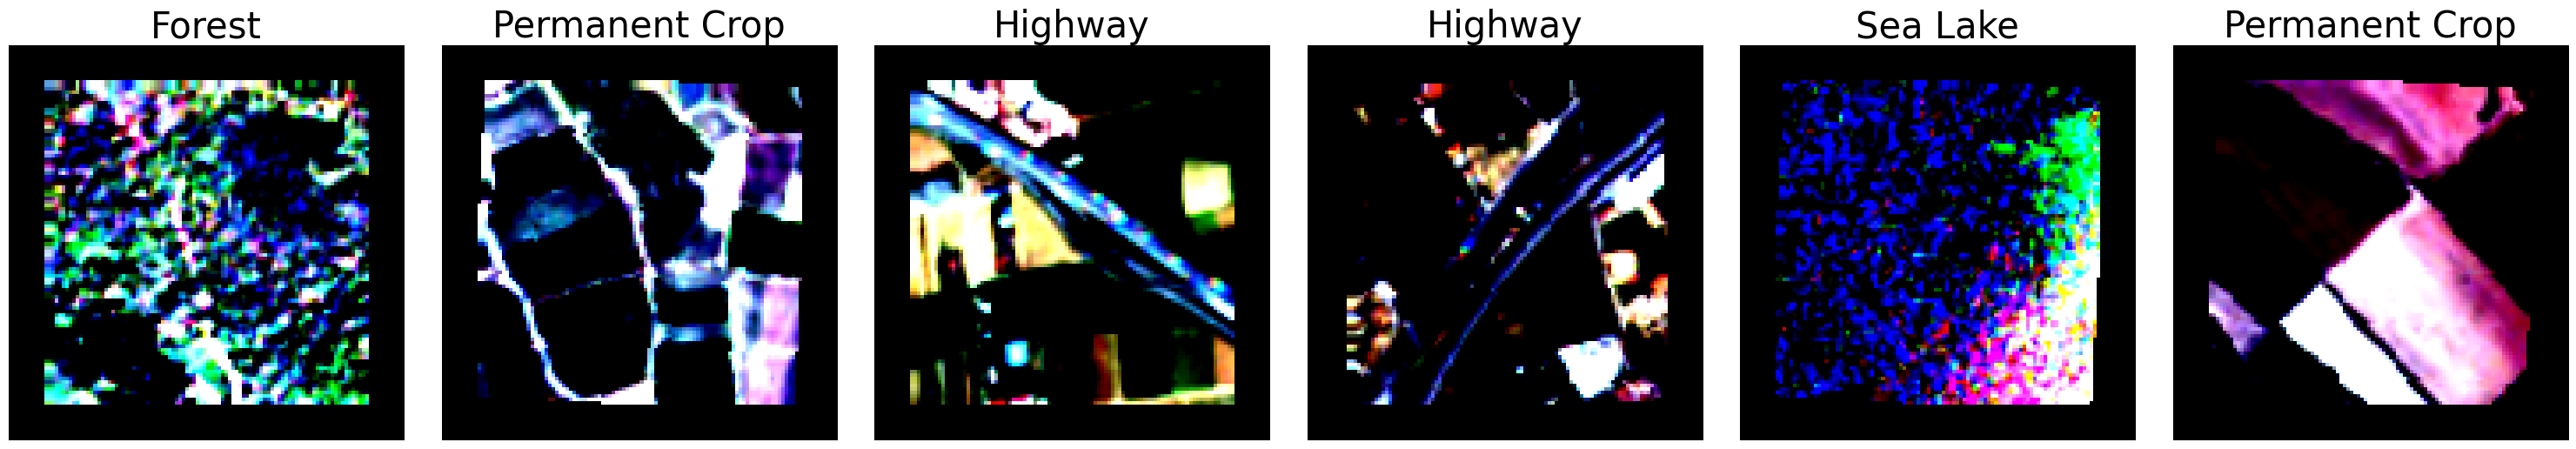

In [ ]:
dataset_first_n(trainset_transformed, 6, ID2LABEL, transformed=True)